# Post-Process of Experimental In-cylinder Pressure Curves to obtain Heat Release Rate Curves

### Author: Alberto Ballerini, STEN Ph.D. student, 38th cycle

## Objective of this project

This code aims to provide an estimation of the Heat Release Rate ($\textit{HRR}$ measured in [J/CAD]) curve from experimental in-cylinder pressure data. The $\textit{HRR}$ measures the power released by the combustion of the fuel, and it can be used to study how the combustion process is evolving over time. 
This quantity is computed as:

$$\textit{HRR} = \frac{dm_\textit{f,b}}{d\theta}$$

where $m_\textit{f,b}$ is the burned mass of fuel and $\theta$ is the crank angle degree measured in [CAD].

Usually, from experimental data, it is only possible to derive the so-called Apparent Heat Release Rate ($\textit{AHRR}$  measured in [J/CAD]) curve, with the formula:

$$\textit{AHRR} = \frac{\gamma}{\gamma - 1}\cdot p \frac{dV}{d\theta} + \frac{1}{\gamma - 1} \cdot V\frac{dp}{d\theta}$$

where:
- $p$ is the in-cylinder pressure in [Pa];
- $V$ is the cylinder volume in [m$^3$];
- $\gamma$ is the ratio of the constant-pressure specific heat and constant-volume specific heat $\gamma = \frac{c_p}{c_v}$;

However, the value of $\textit{AHRR}$ includes the heat transfer between the mixture contained in the combustion chamber and its walls. 
With the knowledge of the heat exchanged with the walls $\frac{dQ_\textit{walls}}{d\theta}$ it is possible to derive the $\textit{HRR}$ from the $\textit{AHRR}$ with the following formula:

$$\textit{HRR} =\textit{AHRR} + \frac{dQ_\textit{walls}}{d\theta}$$

Indeed, in order to estimate correctly the $\textit{HRR}$ from experimental values it is necessary to evaluate the istantaneous heat transfer rate with a specific submodel. In this case the model proposed by Woschni will be used.

Another typical flaw of the $\textit{AHRR}$ formulation presented before is the utilization of a constant $\gamma$. This is done as no experimental informations about the composition and temperature of the charge inside the cylinder are usually available. For this reason, in first approximation, the $\textit{AHRR}$ curve derived is not very representative of the combustion process that is actually happening.

To account for these issues, this code provides an estimation of both the heat transfer and the charge composition to have a better evaluation of the $\textit{HRR}$ through an iterative process. The iterative process stops when the cumulated value of the $\textit{HRR}$ (called Heat Release $\textit{HR}$ measured in [J]) matches the experimental value, as it will be later defined.

## Code documentation

### Import of the necessary libraries

For this code the following libraries will be used:
- __*numpy*__: for array operations;
- __*math*__: to use accurate values of $\pi$;
- __*matplotlib*__: for data visualization.

In [41]:
# -*- coding: utf-8 -*-
# import packages
import numpy as np
import math
import matplotlib.pyplot as plt


### Custom function definition

#### Heat transfer coefficient $h$

In order to obtain an estimation of the heat transfer, the heat transfer coefficient ($h$ measured in [W/m$^2$/K]) has to be computed. The model proposed by Woschni is used to provide this information. With this model, the heat transfer coefficient is evaluated as:

$$ h = C_1\cdot B^{0.2}\cdot p^{0.8}\cdot T^{-0.53}\cdot u^{0.8}$$

where:
- $C_1$ is a calibration constant;
- $B$ is the bore (diameter) of the cylinder in [m];
- $p$ is the in-cylinder pressure in [bar];
- $T$ is the in-cylinder temperature in [K];
- $u$ is the flow speed defined as: $$u = C_2 \cdot u_{p} + C_3 \cdot \bigg(\frac{V T_0}{p_0 V_0}\bigg) \cdot (p - p_{\textit{mot}})$$
in which $C_2$ and $C_3$ are calibration constants, the variables with subscript "0" represents their value at Intake Valve Closing (IVC), $p_{\textit{mot}}$ is the cylinder pressure in motored conditions. This last quantity is computed as: $p_{\textit{mot}} = p_0 \cdot\big(\frac{V_0}{V}\big)^{C_4}$ and $C_4$ is a calibration constant.

To estimate $h$, the function needs as inputs the actual conditions and IVC conditions with the value of $u_p$ and of the bore, as reported in the code hereafter. Moreover, the value of $C_3$ is also an input as it will be changed over the iterations.

In [42]:
# FUNCTIONS
# Define function to get woschnis's coefficients (heat transfer) [W/m^2/K]

def get_woschni_coeff(P_act, T_act, V_act, P_ivc, T_ivc, V_ivc, u_avg, bore_, C3_):

    P0_ = P_ivc/1000
    T0_ = T_ivc
    V0_ = V_ivc

    P_ = P_act/1000
    T_ = T_act
    V_ = V_act

    # set initial value
    htc_ = 0

    C1_ = 5.26
    C2_ = 2.28
    C4_ = 1.32

    P_mot = P0_*(V0_/V_)**C4_
    u_ = C2_*u_avg + C3_*(V_*T0_/(P0_*V0_))*(P_ - P_mot)
    htc_ = C1_ * bore_**(-0.2)*P_**(0.8)*T_**(-0.53)*u_**(0.8)
    return htc_

#### Computation of the constant-pressure specific heat $c_p$

In order to have an accurate estimation of the $\gamma$ it is necessary to consider the dependance on both temperature and mixture composition on the constant-pressure and constant-volume specific heats ($c_p$ and $c_v$). For this reasons, a custom function is defined to compute the value of the molar $c_p$ with the Janaf model. With this formulation the molar $c_p$ is a function of temperature and composition:

$$c_p = (a_0 + a_1 T + a_2 T^2 + a_3 T^3 +a_4 T^4) \cdot R $$

where:
- $R$ is the universal gas constant in [J/mol/K];
- The coefficients $a_j$ with $j = 0,\dots, 4$ are function of the mixture compostion as they are computed as: 
$$a_j = \sum_{i = 1, n} X_i \cdot a_{i,j}$$
in which $X_i$ is the molar composition and $a_{i,j}$ is the $j$-th Janaf coefficient of the $i$-th species in the mixture.
It is important to note that there are actually two sets of Janaf coefficients, one valid for the 300-1000 [K] temperature range, while the other valid in the 1000-5000 [K] range. In fact, later in the code, two matrixes will be declared with the subscript "1000" and "5000" to identify the former and latter ranges respectively.

Knowing the $c_p$ it is possible to compute the molar $c_v$ with Mayer's law:

$$c_v = c_p - R$$

From these values $\gamma$ is derived as $\gamma = \frac{c_p}{c_v}$.

In [43]:
# Define function to get the constant-pressure specific heat
def get_cp(T_, janaf_, comp_):

    a_ = np.dot(janaf_, comp_)
    cp_ = (a_[0] + a_[1]*T_ + a_[2]*T_**2 + a_[3]*T_**3 + a_[4]*T_**4)*8314.5
    return cp_

#### Trapezoidal integration method and moving average filter

These last two functions implemented are used to compute the value of the cumulated integral with the trapezoidal rule (function *trapez_integ*) and to apply a moving average filter (function *moving_average*).

The function *trapez_integ* provides as output a vector in which the $i$-th value is the cumulated integral of the previous values of *Y_in* over the vector *X_*.

The function *moving_average* takes as input the vector *a* and the integer *n* which represents the number of values over which the smoothing will be applied. The output vector *ret* will contain the averaged value over *n* values and will have *n - 1* elements less with respect to the input vector.

In [44]:
# Define function to compute integration with trapezoidal method

def trapez_integ(X_, Y_in):

    step = np.zeros(len(Y_in - 1))
    step = X_[1:len(X_)] - X_[0:len(X_) - 1]
    sum_ = 0
    Y_out = np.zeros(len(Y_in))
    for i in range(len(X_) - 1):
        int_ = (Y_in[i + 1] + Y_in[i])/2*step[i]
        sum_ = sum_ + int_
        Y_out[i + 1] = sum_
    return Y_out

# Define method for moving average filter
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

### Data input for the program

In order to run the script it is necessary to firstly introduce some inputs. In particular the values of Intake Valve Closing (IVC), Exhaust Valve Opening (EVO), Spark Advance (SA) and engine regime have to be set:

In [45]:
# Initial preparation for the script
# Data input to be changed accordingly to the simulated engine
# Intake Valve Closing [CAD]
IVC = -149
# Exhaust Valve Opening [CAD]
EVO = 140
# Spark advance (experimental)
SA = -24
# Engine Regime [RPM]
rpm_ = 1000
rps_ = rpm_/60
speed_ = rps_*360

Moreover, the geometrical aspects of the experimental (and simulated) engine have to be specified:

In [46]:
# Geometry of the engine
bore_ = 0.085           # diameter of the cylinder
stroke_ = 0.088         # lenght of the stroke
rod_length_ = 0.141     # length of the connectig rod
desaxis_ = 0            # disalignment bewteen piston pin and crank
CR_ = 16.40             # compression ratio

u_avg = 2*rps_*stroke_  # mean piston speed

# Surfaces of the combustion chamber
surf_incr = 1.1                         # coefficient to account for increase surface
surf_head = math.pi*bore_**2/4          # head surface
surf_pist = surf_head * surf_incr       # piston top surface

V_disp = stroke_*bore_**2/4*math.pi     # displaced volume

To estimate the heat transfer between the mixture and the combustion chamber walls the temperature of each surface has to be set.

In [47]:
# Temperature of the head, liner and piston top
T_walls = [450, 450, 500]

Additional informations requested are the values of the total mass ($m$ in [kg]) and fuel mass ($m_f$ in [kg]) trapped inside the cylinder at IVC. With them, a guessed value of combustion efficiency $\eta_\textit{comb}$ (i.e. how much of the injected fuel burns during combustion) is necessary. If this information is not available, the suggested value to use is 0.98.

With $m$ and $m_f$ it is possible to derive the mass of fresh air as $m_a = m - m_f$.

In [48]:
# Total mass at intake valve closing (air+fuel) [kg] (experimental)
mass_ = 0.000420889
# Mass of fuel injected [kg] (experimental)
mf_ = 0.00005182
ma_ = mass_ - mf_   # mass of air
# Guessed combustion efficiency (if available)
eff_comb = 0.932

In this section of the code, the inputs regarding the chemical aspects of the mixture are specified. In particular the Lower Heating Value ($LHV$ in [kJ/kg]), the Molar Mass ($\textit{MM}$ in [kg/kmol]), the Janaf coefficients and the atomic composition of the fuel have to be introduced.

In [49]:
# This script considers only the possibility of having the following species in this order
# 1) N2
# 2) O2
# 3) CO2
# 4) H2O
# 5) "fuel species" that can be changed
# Chemical properties of the mixture
LHV_ = 18800  # Lower Heating Value [kJ/kg] 
Rmol_ = 8314.5 # Universal Gas Constant

# Fuel specific properties that are needed in inputs
# Janaf of the fuel: [a_0, a_1, a_2, a_3, a_4]
janaf_1000_fuel = np.array([4.30178, -0.00477127, 2.19342e-05, -2.29856e-08, 8.28992e-12])
janaf_5000_fuel = np.array([2.7171, 0.00556856, -1.76886e-06, 2.67417e-10, -1.52731e-14])

# Molar mass of the fuel
MM_fuel = 17.03056

# Atomic composition of the fuel as:
# [atoms of C, atoms of H, atoms of O, atoms of N]
atoms_fuel = np.array([0, 3, 0, 1])

Now it is possible to set the other chemical parameters for the four remaining species. These properties should not be changed. In this code fresh air is considered as a mixture composed by 79% $N_2$ and 21% $O_2$ on a molar basis.

In [50]:
# Molar Masses
# N2, O2, CO2, H2O, fuel (set later)
MM_ = np.array([28.013, 31.9988, 44.0100, 18.0153, MM_fuel])
# Molar composition of the fresh air
air_comp = np.array([0.79, 0.21, 0, 0, 0])
# Compute molar mass of air
MM_air = np.inner(MM_, air_comp)

# All vectors are ordered in the same way and each property refers to the specie considered
janaf_1000 = np.array([[0.37044177e+1, -0.14218753e-2, 0.28670392e-5, -0.12028885e-8, -0.13954677e-13],
                       [0.37837135e+1, -0.30233634e-2, 0.99492751e-5, -
                        0.98189101e-8, 0.33031825e-11],
                       [0.24007797e+1, 0.87350957e-2, -0.66070878e-5,
                        0.20021861e-8, 0.63274039e-15],
                       [0.41677234e+1, -0.18114970e-2, 0.59471288e-5, -
                        0.48692021e-8, 0.15291991e-11]])

janaf_5000 = np.array([[0.28532899e+1, 0.16022128e-2, -0.62936893e-6, 0.11441022e-9, -0.78057465e-14],
                       [0.36122139e+1, 0.74853166e-3, -0.19820647e-6,
                        0.33749008e-10, -0.23907374e-14],
                       [0.44608041e+1, 0.30981719e-2, -0.12392571e-5,
                        0.22741325e-9, -0.15525954e-13],
                       [0.26110472e+1, 0.31563130e-2, -0.92985438e-6,
                        0.13331538e-9, -0.74689351e-14]])

# Add Janaf of the fuel to Janaf matrix
janaf_1000 = np.transpose(np.vstack([janaf_1000, janaf_1000_fuel]))
janaf_5000 = np.transpose(np.vstack([janaf_5000, janaf_5000_fuel]))

Finally, it is possible to compute the stochiometric air-to-fuel ratio ($\textit{AF}_\textit{stoich}$) and the actual value of the equivalence ratio:

$$\phi =  \frac{\textit{AF}_\textit{stoich}}{\frac{m_a}{m_f}}$$ 

With them the value of heat released by the fuel ($Q_\textit{comb}$ in [J]) is also estimated as:

$$Q_\textit{comb} = m_f \cdot \eta_\textit{comb} \cdot \textit{LHV}$$

In [51]:
# Compute stochiometric air/fuel ratio
AF_stoich = (atoms_fuel[0] + atoms_fuel[1]/4 - atoms_fuel[2]/2) * \
    (MM_[1]+air_comp[0]/air_comp[1]*MM_[0])/MM_[4]
# Equivalence ratio
phi_ = AF_stoich/(ma_/mf_)

# Compute released heat from combustion
Q_comb = mf_*eff_comb*LHV_*1000

### Mixture composition

Having defined all the necessary inputs, it is possible to compute the molar compositions of both the fresh and burnt mixtures ($\overline{X}_\textit{fresh}$ and $\overline{X}_\textit{burnt}$) and their molar mass as they will be later used to estimate the $\gamma$. For the burnt composition, a perfect combustion of the fresh mixture on the value of $\phi$ is considered. The only product of combustion considered from the fuel combustion are $N_2$, $CO_2$ and $H_2O$.

In [52]:
# Compute the composition of the ideally burned mixture
mol_comb = mf_/MM_[4]
fresh_moles = np.array([])
fresh_moles = ma_/MM_air*air_comp
fresh_moles[4] = mol_comb
fresh_comp = fresh_moles/np.sum(fresh_moles)
MM_fresh = np.inner(MM_, fresh_comp)
# Initialize vectors
burnt_comp = np.zeros(len(fresh_moles))
burnt_moles = np.zeros(len(fresh_moles))
# perfect combustion calculation
if phi_ <= 1:  # lean combustion
    burnt_moles[0] = fresh_moles[0] + mol_comb * \
        (atoms_fuel[3]/2)                                              # N2
    burnt_moles[1] = fresh_moles[1] - mol_comb * \
        (atoms_fuel[0] + atoms_fuel[1]/4 - atoms_fuel[2]/2)            # O2
    burnt_moles[2] = fresh_moles[2] + mol_comb * \
        (atoms_fuel[0])                                                # CO2
    burnt_moles[3] = fresh_moles[3] + mol_comb*(atoms_fuel[1]/2)       # H2O
    burnt_moles[4] = fresh_moles[4] - mol_comb                         # Fuel
else:          # rich or stochiometric combustion
    mol_comb_burnt = fresh_moles[1]/(atoms_fuel[0] + atoms_fuel[1] /
                                     4 - atoms_fuel[2]/2)              # moles of fuel that can burn
    burnt_moles[0] = fresh_moles[0] + mol_comb_burnt * \
        (atoms_fuel[3]/2)                                              # N2
    burnt_moles[1] = 0                                                 # O2
    burnt_moles[2] = fresh_moles[2] + mol_comb_burnt*(atoms_fuel[0])   # CO2
    burnt_moles[3] = fresh_moles[3] + mol_comb_burnt*(atoms_fuel[1]/2) # H2O
    burnt_moles[4] = fresh_moles[4] - mol_comb_burnt                   # fuel

# Compute composition and molar mass
burnt_comp = burnt_moles/np.sum(burnt_moles)
MM_burnt = np.inner(MM_, burnt_comp)

### Iterative process to evaluate HRR

As stated before, the objective of this code is to provide an estimation of the $\textit{HRR}$. For this reason, it is necessary that the Heat Release computed matches the experimental heat released by combustion $Q_\textit{comb}$. To obtain this matching, an iterative process that changes the value of the calibration constant $C_3$ is performed. Moreover, at each iteration, the composition, $\gamma$ of the mixture and the heat transfer with the walls are estimated with the data derived from the previous iteration.

#### Computation of the initial guess

Firstly, the experimental data are read from the "*Experimental.csv*" file. This file has as first column the crank angles and as second column the pressure in [bar], separated by a comma. The values of crank angle and pressure are then stored in two vectors. If necessary, it is possible to apply a smoothing function to the pressure vector.

In [53]:
# Read experimental data from csv with first column angles and second column pressure in [Bar]
exp_data = np.loadtxt("Experimental.csv", delimiter=",")
angle_vect = exp_data[:, 0]
pressure_vect = exp_data[:, 1]*1e5

# Apply smoothing (set 1 to avoid smoothing)
pressure_vect = moving_average(pressure_vect, 1)

The volume of the cylinder is a function of the crank angle the geometrical characteristics of the cylinder itsef.

In [54]:
# Compute volume and surface vectors as function of the crank angle
volume_vect = np.array([])
stroke_vect = ((((2*rod_length_/stroke_ + 1)**2 - (2*desaxis_/stroke_)**2)**0.5 - np.cos(angle_vect/180*math.pi)
                - ((2*rod_length_/stroke_) ** 2 - ((2*desaxis_/stroke_ - np.sin(angle_vect/180*math.pi))**2))**0.5)/2
               + 1/(CR_ - 1))*stroke_
volume_vect = stroke_vect*bore_**2*math.pi/4
surf_liner_vect = stroke_vect*math.pi*bore_

Having defined the pressure and angle vectors, it is appropriate to filter the data in order to reduce the possible numerical oscillations in post process. Usually, the outputs of experimental pressure are given every 0.1 crank angle degree. For this reason, a filtering step of 10 is set to obtain the value of pressure at every integer angle.

The pressure, volume and surface vectors are filtered in the same manner and it is now possible to compute the derivative of pressure and cylinder volume.

In [55]:
# Filter experimental data (to reduce oscillations in post)
step_filt = 10
filter_vect = np.arange(0, np.size(pressure_vect), step_filt)

# Limit between IVC and EVO
angle_filt = angle_vect[filter_vect]
ind_IVC = np.where(angle_filt >= IVC)[0][0]
ind_SA = np.where(angle_filt >= SA)[0][0]
ind_EVO = np.where(angle_filt >= EVO)[0][0]

# filter index
ind = [ind_IVC, ind_EVO]

angle_filt = angle_filt[ind[0]:ind[1]]
filter_vect = filter_vect[ind[0]:ind[1]]

# Prepare filtered vectors
pressure_filt = pressure_vect[filter_vect]
volume_filt = volume_vect[filter_vect]
surf_liner_filt = surf_liner_vect[filter_vect]

# Compute pressure derivative with forward, backward and centered difference schemes
dP = np.array([])
dP_fg = pressure_filt[1:len(pressure_filt)] - pressure_filt[0:len(pressure_filt)-1]
dP_fw = pressure_filt[2:len(pressure_filt)-1] - pressure_filt[1:len(pressure_filt)-2]
dP_bw = pressure_filt[1:len(pressure_filt)-2] - pressure_filt[2:len(pressure_filt)-1]
dP = (dP_fw - dP_bw)/2
dP = np.append(dP_fg[0], dP)
dP = np.append(dP, dP_fg[-1])

# Compute angle derivative
dAngle = np.array([])
dAngle = angle_filt[1:len(angle_filt)] - angle_filt[0:len(angle_filt)-1]

# Compute volume derivative
dVolume = np.array([])
dVolume = volume_filt[1:len(volume_filt)] - volume_filt[0:len(volume_filt)-1]

In order to start the iterative process, a first guess of the $\textit{AHRR}$ with a constant $\gamma$ is computed.

In [56]:
# Start of the iterative process to compute the Heat Release Rate
# First guess of AHRR with a constant gamma (cp/cv)
AHRR = np.array([])
gamma_cost = 1.30

len_vect = len(pressure_filt)
AHRR = gamma_cost/(gamma_cost-1)*pressure_filt[0:len_vect-1] * \
    dVolume/dAngle + 1/(gamma_cost-1)*volume_filt[0:len_vect-1]*dP/dAngle

AHRR = np.append(AHRR, 0)

Having this vector, it is possible to compute the cumulated value of $\textit{AHRR}$, called Apparent Heat Release ($\textit{AHR}$ measured in [J]) as:

$$ \textit{AHR} = \int_\textit{IVC}^\textit{EVO} \textit{AHRR} \ d\theta$$

with the function *trapez_integ*. Then the minimum value of $\textit{AHR}$ is summed to $\textit{AHR}$ to obtain a vector with non-negative values.

After this operation, the Start Of Combustion (SOC) and End Of Combustion (EOC) angles are identified. The SOC is set to be equal to the SA, while the EOC is identified as the angle at which $\textit{AHR}$ is positive and the value of $\textit{AHRR}$ at the same angle is negative. This angle is used as EOC with the hypothesis that combustion has ended as the value of $\textit{AHRR}$ is equal to the heat exchanged with the walls, which is negative because the temperature of the burned charge is greater than the one of the walls.

In [57]:
# Compute cumulated value of AHRR and shift to have non-negative values
AHR = trapez_integ(angle_filt, AHRR)
AHR = AHR + abs(np.min(AHR))

# Identify Start Of Combustion (SOC) and End Of Combustion (EOC)
# SOC is set to be the Spark Advance (SA)
SOC = SA
ind_SOC = np.where(angle_filt >= SOC)[0][0]
# EOC is the angle at which AHR is positive and the value of AHRR at same angle is negative
EOC = angle_filt[np.where((AHR > 0) & (AHRR < 0) & (angle_filt > 0))][0]
ind_EOC = np.where(angle_filt == EOC)[0][0]

To compute a first estimation of the heat exchanged, and so the $\textit{HRR}$, the temperature of the mixture and the heat transfer coefficient $h$ have to be evaluated at each crank angle. In order to do so, the instantaneous composition of the charge is computed as a function of the burned mass fraction $x_b$. The value of $x_b$ at each crank angle can be estimated from the vector $\overline{\textit{AHR}}$ by normalizing it and multiplying it by $\eta_\textit{comb}$. With this operation, the vector $\overline{x}_b$ is obtained and can be used to evaluate the mixture composition.

In [58]:
# First guess of Xb (burned mass fraction)
HR_fg = AHR
HR_fg[np.where(angle_filt < SOC)] = 0               # before combustion starts HRR is zero
HR_fg[np.where(angle_filt > EOC)] = AHR[ind_EOC]    # after EOC the value is fixed

# Compute the burned mass fraction by normalizing AHR
Xb_fg = HR_fg/(np.max(HR_fg) - np.min(HR_fg))*eff_comb

# Compute istantaneous composition for each crank angle from burned mass fraction
# Define vectors
ist_moles = np.zeros((len(angle_filt), len(fresh_moles)))
ist_comp = np.zeros((len(angle_filt), len(fresh_moles)))
MM_ist = np.zeros(len(angle_filt))
R_ist = np.zeros(len(angle_filt))

Having the value of $\overline{x}_b$, it is possible to compute the molar composition of the charge. Firstly the moles of each component are evaluated:

$$ \overline{N} = m \cdot \big((1 - x_b) \cdot \overline{X}_\textit{fresh} / \textit{MM}_\textit{fresh} + x_b \cdot \overline{X}_\textit{burnt}/ \textit{MM}_\textit{fresh} \big)$$

where $\overline{X}_\textit{fresh}$ and $\overline{X}_\textit{burnt}$ are the vectors containing the molar composition of the "fresh" and "burnt" zones that compose the overall mixture.
Then, the molar composition at each crank angle degree is derived:

$$ \overline{X} = \frac{\overline{N}}{\sum_{i=1}^5 N_i}$$ 

and with it the molar mass and massic gas constant $R^*$:

$$ \textit{MM} = \sum_{i=1}^5 X_i \cdot \textit{MM}_i  \\ R^* = \frac{R}{MM}$$

With this information, the temperature is computed with the ideal gas law:

$$T = \frac{p \cdot V}{m R^*}$$

The value of $p, V, m$ and $R^*$ are taken at the same angle and the output of this operation is another vector containing the temperature values. Moreover, the conditions at IVC are identified and stored in specific variables as they will be needed later.

In [59]:
# Compute the molar composition at each angle
for i in range(len(angle_filt)):
    ist_moles[i, :] = mass_*((1 - Xb_fg[i])*fresh_comp/MM_fresh + Xb_fg[i]*burnt_comp/MM_burnt)
    ist_comp[i, :] = ist_moles[i, :]/np.sum(ist_moles[i, :])    # Composition
    MM_ist[i] = np.inner(MM_, ist_comp[i, :])                   # Molar mass
# Compute the massic gas constant
R_ist = Rmol_/MM_ist
# Compute the in-cylinder temperature at each step with the new composition (with Ideal gas law)
temperature_filt = np.zeros(len(angle_filt))
temperature_filt = pressure_filt*volume_filt/mass_/R_ist

# Get values of P, V, R* and T at Intake Valve Closing
P_IVC = pressure_vect[ind_IVC]
V_IVC = volume_vect[ind_IVC]
R_IVC = Rmol_/MM_fresh
T_IVC = P_IVC * V_IVC / (mass_*R_IVC)

Finally, it is possible to estimate the heat transfer coefficient $h$ and the heat exchanged with the combustion chamber's surfaces. Firstly, the vector containing the value of the tuning constant $C_3$ has to be populated. This vector is set equal to $0$ until SOC, and after it a fixed value is used. This value which will be changed over the iterations to reach convergence with the experimental heat released by combustion.

In [60]:
# Value of C3 (in Woschni's model) for compression
C3_comp = 0
# C3_comb is the value that will be changed over the iterations
C3_comb = 3.24e-3

# Initialize vectors
C3_filt = np.zeros(len(angle_filt))
C3_filt[np.where(HR_fg == 0)] = C3_comp
C3_filt[np.where(HR_fg > 0)] = C3_comb

Having defined the $C_3$ vector, $h$ is evaluated at each angle with the *get_woschni_coeff* function. 
The, the heat transfer with the walls can be computed as:

$$ \frac{dQ_\textit{walls}}{d\theta} = h \cdot (A_\textit{head}(T - T_\textit{head}) + A_\textit{top}(T - T_\textit{top}) + A_\textit{liner}(T - T_\textit{liner})) $$

where $A_\textit{head}, A_\textit{top}$ and $A_\textit{liner}$ are the surface of each wall in the combustion chamber measured in [m$^2$] and derived from the geometrical inputs.

By adding $\frac{dQ_\textit{walls}}{d\theta}$ to $\textit{AHRR}$ the vector $\textit{HRR}$ is obtained. This is then processed to be consistent with the physical meaning of the $\textit{HRR}$. For this reason, the values before SA are set to 0 and the actual SOC is defined as the first angle after which the following seven values of $\textit{HRR}$ are positive (i.e. the charge is burning). Instead, the EOC is identified as the first angle after SOC at which the value of $\textit{HRR}$ is negative. The values after EOC are also set to 0 as no more fuel is considered to be able to burn.

Finally, by using the *trapez_integ* function, the vector $\textit{HR}$ is obtained and with it the first estimation of the target error ($\textit{err}$ in [\%]) defined as:

$$ \textit{err} = \frac{\textit{HR}(end) - Q_\textit{comb}}{Q_\textit{comb}} \cdot 100 $$

where $\textit{HR}(end)$ is the last value of the $\textit{HR}$ vector, and its physical meaning is the estimation of the heat released by the fuel combustion.

In [61]:
dQ_filt = np.zeros(len(angle_filt))
htc_filt = np.zeros(len(angle_filt))
# Estimate heat transfer coefficient at each crank angle [W/m^2/K]
htc_filt = np.array([get_woschni_coeff(pressure_filt[i], temperature_filt[i], volume_filt[i],
                    P_IVC, T_IVC, V_IVC, u_avg, bore_, C3_filt[i]) for i in range(len(angle_filt))])
htc_filt = htc_filt/speed_ # to pass from [w/m^2/K] to [J/CAD/m^2/K]
# Compute heat transfer, sum of the various terms over the head, liner and piston top
dQ_filt = np.array([htc_filt[i]*(surf_head*(temperature_filt[i]-T_walls[0])
                    + surf_pist*(temperature_filt[i]-T_walls[2])
                    + surf_liner_filt[i]*(temperature_filt[i] - T_walls[1]))
                    for i in range(len(angle_filt))])

# First guess of Heat Release Rate
HRR = AHRR + dQ_filt
HRR[angle_filt < SA] = 0
Mask = -1*np.ones(len(HRR))
Mask[HRR >= 0] = 1
Mask[angle_filt < SA] = 0
Mask_2 = np.array([np.min(Mask[i:i+7]) for i in range(len(Mask)-7)])
Mask_2 = np.append(Mask_2, np.ones(7))
# The actual start of combustion is identified as the first angle at which the first 7 values are positive
ind_SOC = np.where(Mask_2 > 0)[0][0]
HRR[0:ind_SOC] = 0
ind_EOC = np.where(HRR < 0)[0][0]
HRR[ind_EOC:] = 0
# Cumulated value
HR = trapez_integ(angle_filt, HRR)

# The iteration over C3 are done to match the experimental value of heat released by the fuel,
# which is computed as the mass of fuel*combustion efficiency*LHV
err = (HR[-1] - Q_comb)/Q_comb*100

#### Iterative loop

After computing the initial guess, it is possible to start the iterative loop.
As already said, it is necessary to provide an accurate estimation of the $\gamma$ in order to obtain a meaningful result. For this reason the value of $\gamma$ at each crank angle degree is computed by using the composition and temperature estimation obtained from the previous iteration. 

It is important to notice that the Janaf coefficients are chosen accordingly to the temperature validity range considered at each crank angle.

With the values of $\gamma$ it is possible to compute again the $\textit{AHRR}$ vector and repeat the steps applied for the initial guess.

After the new estimation of both $\textit{HRR}$ and $\textit{HR}$ the program prints to screen the iteration number and the value computed of the heat released by combustion. 

Then, the new error is evaluated and the value of the constant $C_{3,\textit{comb}}$ in combustion is changed as follows:

$$ C_{3,\textit{comb}}^{n+1} = C_{3,\textit{comb}}^{n}\cdot(100 - \textit{err}) \cdot (1 - \beta) + \beta \cdot C_{3,\textit{comb}}^{n} $$

where $n$ represents the $n$-th iteration and $\beta$ is an under-relaxing factor.

The code also prints the new coefficient used and the error at the end of the iteration.

In [62]:
# Start the iteration
iteraz = 0

while abs(err) > 0.1 and iteraz <= 1000:
    # Get gamma at each time step for next iteration
    cp_filt = np.zeros(len(angle_filt))
    gamma_filt = np.zeros(len(angle_filt))
    for i in range(len(angle_filt)):
        janaf_temp = janaf_1000
        if temperature_filt[i] > 1000:
            janaf_temp = janaf_5000

        cp_filt[i] = get_cp(temperature_filt[i], janaf_temp, ist_comp[i, :])
        gamma_filt[i] = cp_filt[i]/(cp_filt[i] - Rmol_)

    gamma = gamma_filt[0:len(gamma_filt) - 1]

    # Compute new AHRR with variable gamma
    AHRR = gamma/(gamma - 1)*pressure_filt[0:len_vect - 1] * \
        dVolume/dAngle + 1/(gamma - 1)*volume_filt[0:len_vect - 1]*dP/dAngle
    AHRR = np.append(AHRR, 0)
    AHR = trapez_integ(angle_filt, AHRR)
    AHR = AHR + abs(np.min(AHR))

    # Identify new SOC and EOC
    SOC = SA
    ind_SOC = np.where(angle_filt >= SOC)[0][0]
    EOC = angle_filt[np.where((AHR > 0) & (AHRR < 0) & (angle_filt > 0))][0]
    ind_EOC = np.where(angle_filt == EOC)[0][0]

    # Guess for Xb
    HR_fg = AHR
    HR_fg[np.where(angle_filt < SOC)] = 0
    HR_fg[np.where(angle_filt > EOC)] = AHR[ind_EOC]
    Xb_fg = HR_fg/(np.max(HR_fg) - np.min(HR_fg))*eff_comb

    # Compute new composition and properties
    ist_moles = np.zeros((len(angle_filt), len(fresh_moles)))
    ist_comp = np.zeros((len(angle_filt), len(fresh_moles)))
    MM_ist = np.zeros(len(angle_filt))
    R_ist = np.zeros(len(angle_filt))
    for i in range(len(angle_filt)):
        ist_moles[i, :] = mass_*((1-Xb_fg[i])*fresh_comp/MM_fresh + Xb_fg[i]*burnt_comp/MM_burnt)
        ist_comp[i, :] = ist_moles[i, :]/np.sum(ist_moles[i, :])
        MM_ist[i] = np.inner(MM_, ist_comp[i, :])
    R_ist = Rmol_/MM_ist

    # Evaluate temperature at each step
    temperature_filt = np.zeros(len(angle_filt))
    temperature_filt = pressure_filt*volume_filt/mass_/R_ist

    # Evaluate heat transfer and heat exchanged
    C3_comb_old = C3_comb
    C3_filt = np.zeros(len(angle_filt))
    C3_filt[np.where(HR_fg == 0)] = C3_comp
    C3_filt[np.where(HR_fg > 0)] = C3_comb

    dQ_filt = np.zeros(len(angle_filt))
    htc_filt = np.zeros(len(angle_filt))

    # Compute heat transfer coefficient [W/m^2/K]
    htc_filt = np.array([get_woschni_coeff(pressure_filt[i], temperature_filt[i], volume_filt[i],
                        P_IVC, T_IVC, V_IVC, u_avg, bore_, C3_filt[i]) for i in range(len(angle_filt))])

    htc_filt = htc_filt/speed_
    dQ_filt = np.array([htc_filt[i]*(surf_head*(temperature_filt[i]-T_walls[0])
                       + surf_pist*(temperature_filt[i]-T_walls[2])
                       + surf_liner_filt[i]*(temperature_filt[i] - T_walls[1]))
        for i in range(len(angle_filt))])

    # compute HRR
    HRR = AHRR + dQ_filt
    AHR = trapez_integ(angle_filt, AHRR)

    # HRR before SA is null
    HRR[angle_filt < SA] = 0
    Mask = -1*np.ones(len(HRR))
    Mask[HRR >= 0] = 1
    Mask[angle_filt < SA] = 0
    Mask_2 = np.array([np.min(Mask[i:i+7]) for i in range(len(Mask)-7)])
    Mask_2 = np.append(Mask_2, np.ones(7))
    # The actual start of combustion is identified as the first angle at which the first 7 values are positive
    ind_SOC = np.where(Mask_2 > 0)[0][0]
    HRR[0:ind_SOC] = 0
    # print(HRR)
    ind_EOC = np.where(HRR < 0)[0][0]
    HRR[ind_EOC:] = 0
    HR = trapez_integ(angle_filt, HRR)
    Xb = HR/np.max(HR)*eff_comb
   
    # Print to screen the iterations
    print("-------------------------")
    print("Iteration n° : ", iteraz)
    print("Heat released by combustion : %8.2f" % HR[-1])
    err = (HR[-1] - Q_comb)/Q_comb*100
    beta = 0.9
    # Compute new value of C3
    C3_comb = (C3_comb_old * (100 - err)/100*(1 - beta) + beta*C3_comb_old)
    print("New coefficient is : %8.5f" % C3_comb)
    print("Error : %8.5f" % err)
    # Increase iteration counter
    iteraz = iteraz + 1

-------------------------
Iteration n° :  0
Heat released by combustion :   822.14
New coefficient is :  0.00327
Error : -9.45240
-------------------------
Iteration n° :  1
Heat released by combustion :   822.88
New coefficient is :  0.00330
Error : -9.37130
-------------------------
Iteration n° :  2
Heat released by combustion :   823.10
New coefficient is :  0.00333
Error : -9.34706
-------------------------
Iteration n° :  3
Heat released by combustion :   823.34
New coefficient is :  0.00336
Error : -9.32100
-------------------------
Iteration n° :  4
Heat released by combustion :   823.58
New coefficient is :  0.00339
Error : -9.29480
-------------------------
Iteration n° :  5
Heat released by combustion :   823.81
New coefficient is :  0.00343
Error : -9.26844
-------------------------
Iteration n° :  6
Heat released by combustion :   824.06
New coefficient is :  0.00346
Error : -9.24193
-------------------------
Iteration n° :  7
Heat released by combustion :   824.30
New coe

### Final results

After the iterative code has reached convergence, or the number of iterations exceed the maximum value, the obtained results are plotted against the values obtained from the simulations.

The simulated data is read from two comma separated values files that have to be present in the folder where the program is saved (otherwise the path has to be changed). From the "*burntMass.csv*" file the $\textit{HRR}$ computed by the simulations is extracted, while from "*cylPres.csv*" the simulated in-cylinder pressure is obtained.

In [63]:
# %% Read data from simulations
burntMass = np.loadtxt('./burntMass.csv', delimiter=",", skiprows=2)
cylPress = np.loadtxt('./cylPres.csv', delimiter=",", skiprows=2)

Two graphs are plotted, one for the in-cylinder pressure and one for the $\textit{HRR}$. In both figures, the experimental curve is represented in a dashed black line and the simulated one in red continuous one.

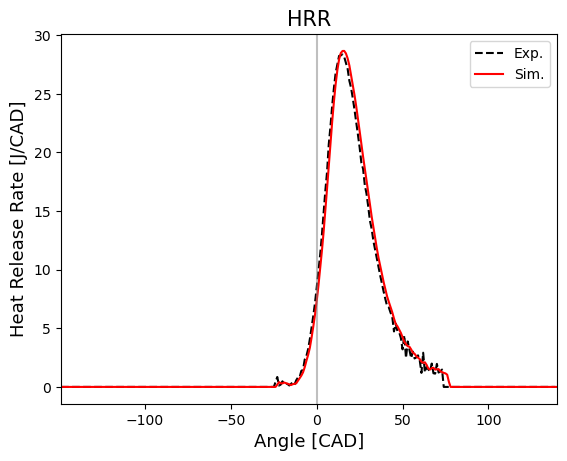

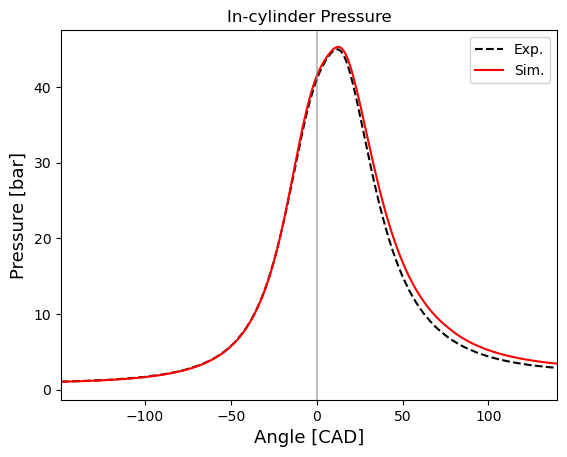

In [64]:
# %% Plot data with matplotlib and save in the folder

# Define labels and limits for plots
Lab_cad = "Angle [CAD]"
titleSize = 15
LabSize = 13

# Heat Release Rate curve
plt.figure(1)
plt.title("HRR", fontsize=titleSize)
plt.plot(angle_filt, HRR, label="Exp.", color="k", ls='--')
plt.plot(burntMass[:, 0], burntMass[:, 5], label="Sim.",  color="r", ls='-')
plt.axvline(x=0, color='grey', alpha=0.5)
plt.xlabel(Lab_cad, fontsize=LabSize)
plt.ylabel("Heat Release Rate [J/CAD]", fontsize=LabSize)
plt.xlim([IVC, EVO])
plt.legend()
plt.savefig("./HRR.png", format="png", dpi=300)

# Pressure curve
plt.figure(2)
plt.title("In-cylinder Pressure")
plt.plot(angle_filt, pressure_filt/1e5, color="k",ls='--', label="Exp.")
plt.plot(cylPress[:, 0]-360, cylPress[:, 2],
         label="Sim.", color="r", ls='-')
plt.axvline(x=0, color='grey', alpha=0.5)
plt.xlabel(Lab_cad, fontsize=LabSize)
plt.ylabel("Pressure [bar]", fontsize=LabSize)
plt.xlim([IVC, EVO])
plt.legend()
plt.savefig("./pressure.png", format="png", dpi=300)

Both figures have the same x-axis labels and ticks and a grey line at $\theta$ = 0 is reported to identify the Top Dead Center (TDC).
The figures are saved in the program folder as _".png"_ figures to be used in presentation or documents.